In [1]:
import data
from utils import distances, draw
import ETC
# from ETC.CCMC.pairs import ETC_causality, LZ_causality
import numpy as np
# from utils import draw
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

## Definitions:

Every song is represented as a dictionary with the following attributes:
- `melody`: this is an integer array that represents the distance(in semitones) of the notes used in the song from its key or tonic. As a result, we obtain a scale-invariant version of the song's melody.
    > Note: Since any song rarely spans more than three octaves, for most of the songs, the elements in this array will lie in the interval $[-12, 24]$. We denote rests with an integer value which is unlikely to be spanned in any song. In our case, we denote it by the index 99999. However, for ETC and distance metric calculations, the rests have been pruned out.
- `durations`: this array stores the durations of the occurring notes relative to the length of every measure of the beat. Hence, a **Quarter Note** corresponds to a value of $0.25$.
- `measure_onsets`: this array is just a positional encoder, which stores a value of $1$ for the first beat of every measure, and $0$ for other beats.
- `int_durations`: the elements of this array can be calculated as follows:
    \begin{align}
    int\_durations_i &= \lceil durations_i * 480 \rceil
    \end{align}
    Even though the smallest duration note found throughout all the songs was the sixteenth note, not all the notes that appear in the songs have a duration that corresponds to an inverse power of 2. They can be triplets, or fifth-notes etc. By using $480$ as the multiplier, we were able to convert all the durations into integer values.
- `adjusted_melody`: this array is basically every element of `melody`, repeated through the corresponding value of `int_durations`. This way, larger duration notes are proportionally repeated more times as compared to the smaller duration ones.

In [3]:
data.compute_adjusted_melody()
dicts = data.GetAll()
# print(compute_etc(dicts))
# for drawing graph, visit: https://bit.ly/3pL7sQm


## Data Processing:

The `get_etc_modified_data()` method below performs the required pre-processing on the data. By default, it returns the `adjusted_melody`, but each element is incremented by $24$ and rests are represented by the number $200$. This way, data can be represented within the limits of the etc calculation algorithm.

If `num_bins` $ = 2$, then we bin the notes relative to the major 7$^{th}$ (which is equivalent to the _Pancham_ in Indian Art Music) into a total of $2$ bins. As this is a relative binning strategy, rests are ignored.

In [4]:
def get_etc_modified_data(dict, include_rests=True, num_bins=None):
    ret = []
    if num_bins != None:
        include_rests = False
    for ind in range(len(dict["adjusted_melody"])):
        if num_bins == 2 and dict["adjusted_melody"][ind] != 99999:
            if dict["adjusted_melody"][ind] > 7:
                ret.append(2)
            else:
                ret.append(1)
        elif include_rests:
            if dict["adjusted_melody"][ind]< 99999:
                ret.append(dict["adjusted_melody"][ind] + 24)
            else:
                ret.append(99999)
        else:
            if dict["adjusted_melody"][ind] < 99999:
                ret.append(dict["adjusted_melody"][ind] + 24)

    return ret


print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, num_bins=2))
print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, include_rests=True))
print(get_etc_modified_data(data.AH_VOUS_ORIGINAL, include_rests=False))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## Feature Extraction:

### Effort-To-Compress(ETC)

ETC effectively calculates the number of recursions of a lossless compression algorithm required for finding the optimum compressibility. Currently, the Non-Sequential Recursive Pair Substitution is being used as the lossless compression algorithm.

<ipython-input-5-bb9bc4daa634>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(etcs.keys(), rotation = 45, ha="right")


<BarContainer object of 10 artists>

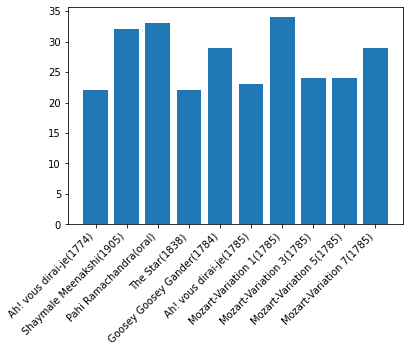

In [5]:
def compute_etc(dicts):
    etcs = {}
    for dict in dicts:
        m_dict = get_etc_modified_data(dict, num_bins=2)
        etcs[data.GetLabels()[dicts.index(dict)]] = ETC.compute_1D(m_dict, order=2, verbose=False, truncate=True)["ETC1D"]
    return etcs

fig = plt.figure(1)
ax = fig.add_subplot(111)
etcs = compute_etc(dicts)
ax.tick_params(axis='both', which='major')
ax.set_xticklabels(etcs.keys(), rotation = 45, ha="right")
plt.bar(etcs.keys(), etcs.values())

##### Inference from the ETC values:

- The 1774 and 1785 versions  of *Ah! Vous Dirai-Je, Maman*  are very similar, and have the lowest ETC values, meaning, they are the simplest pieces and hence,  the easiest to compress.
- The Carnatic Counterparts, being derivatives, have a significantly higher ETC value.
- Goosey Goosey Gander(1784) is also a derivative, and follows the trend.
- The Star(more popular as Twinkle Twinkle Little Star in modern times) simply had the same melody as the 1774 version of Ah! vous dirai-je, and this is reflected in their ETC values.
- Mozart's variations were directly derived from the 1785 version, and they too follow the trend.

### Distance Metrics

#### Longest Common Subsequence(LCS)

LCS, as the name suggests, is the length of the longest common subsequence between a pair of sequences. For example, consider string sequences `QUIVER` and `VERSION`. It is clear that the longest common subsequence between this pair of sequences is the subsequence `VER` and has a length 3. Naturally, LCS length invariant i.e. it doesn't matter if the sequences are of different lengths. LCS also follows the law of commutativity: $LCS(X, Y) = LCS(Y, X)$

In our experiments, LCS can help capture the longest continuous occurrence of a phrase in a pair of different melodies. LCS is primarily effective when `melody` is used instead of `adjusted_melody` in the data processing step.

#### Edit Distances(ED)

Edit Distance is the minimum number of edits required to make a pair of sequences equal to one another. For example, consider a pair of strings `TONIGHT` and `FORTNIGHT`. The edit distance is $3$ since $3$ 'edits' are required to convert the substring `TON` $\leftrightarrow$ `FORT`. The edit distance between the pair of strings `QUIVER` and `VERSION` will be $6$.

#### Hamming Distance(HD)

According to the documentation in `SciPy`:
> Hamming Distance is simply the proportion of disagreeing elements in a pair of sequences of the same length.

Hamming Distance can be calculated as:

\begin{align}
    HD(X, Y) &= \frac{\sum_{i = 1}^N (x_i \neq y_i)}{N}
\end{align}
where $N$ is the length of sequences $X$ and $Y$ and $x_i \in X$, $y_i \in Y$


#### ETC Distance($d_{ETC}$)

For computing the ETC distance ($d_{ETC}$) between a pair of sequences, the sequences are first concatenated, ETC is computed for both the concatenated and individual sequences, and then the average is calculated, as shown below:

\begin{align}
    d_{ETC}(X, Y) &= \frac{ETC(XY) + ETC(YX) - ETC(X) - ETC(Y)}{2}
\end{align}

Using the above distance metrics, pairwise distances can be tabulated in to a matrix. Below are a few examples:

In [6]:
def create_matrix_melody_distances(dict_list):
    LCSMatrix = np.zeros((len(dict_list), len(dict_list)))
    EDMatrix = np.zeros((len(dict_list), len(dict_list)))
    DTWMatrix = np.zeros((len(dict_list), len(dict_list)))
    HDMatrix = np.zeros((len(dict_list), len(dict_list)))
    dETCMatrix = np.zeros((len(dict_list), len(dict_list)))
    Causility_Matrix = np.zeros((len(dict_list), len(dict_list)))
    Causility_Matrix_LZ = np.zeros((len(dict_list), len(dict_list)))
    Causility_Matrix_ETCP = np.zeros((len(dict_list), len(dict_list)))

    for i in range(len(dict_list)):
        m_i = get_etc_modified_data(dict_list[i])
        m_i_no_rests = get_etc_modified_data(dict_list[i], include_rests=False)
        for ii in range(len(dict_list)):
            m_ii = get_etc_modified_data(dict_list[ii])
            m_ii_no_rests = get_etc_modified_data(dict_list[ii], include_rests=False)
            LCSMatrix[i][ii] = distances.LCSubSeq(m_i, m_ii, len(m_i), len(m_ii))
            EDMatrix[i][ii] = distances.editDist(m_i, m_ii, len(m_i), len(m_ii), normalize_len=True)
            print(m_ii_no_rests, m_i_no_rests)
            # DTWMatrix[i][ii] = distances.dtwDist(m_i_no_rests, m_ii_no_rests, len(m_i_no_rests), len(m_ii_no_rests))
            HDMatrix[i][ii] = distances.hammingDist(m_i, m_ii, len(m_i), len(m_ii))
            dETCMatrix[i][ii] = distances.etcDist(m_i, m_ii)
            Causility_Matrix[i][ii] =  1 if ETC.CCM_causality(data.PruneRests(m_i), data.PruneRests(m_ii))['ETCE_cause'] == 'x' else 0
            Causility_Matrix_LZ[i][ii] =  1 if ETC.CCM_causality(data.PruneRests(m_i), data.PruneRests(m_ii))['LZP_cause'] == 'x' else 0
            Causility_Matrix_ETCP[i][ii] =  1 if ETC.CCM_causality(m_i, m_ii)['ETCP_cause'] == 'x' else 0


    return LCSMatrix, EDMatrix, DTWMatrix, HDMatrix, dETCMatrix, Causility_Matrix, Causility_Matrix_LZ, Causility_Matrix_ETCP


def get_significant_distances(arr):
    labels = data.GetSignificantLabels()
    n_elements = len(labels)
    new_arr = arr[0:n_elements, 0:n_elements]
    return new_arr

In [6]:
%matplotlib inline
import seaborn as sns

arrs = create_matrix_melody_distances(data.GetAll())

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 33, 33, 33, 33, 33, 33, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 26, 26, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,

<ipython-input-7-b907aa6e5970>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(arrs[2], 'weighted')
/home/efm-workstation/miniconda3/envs/efm/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:2864: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim([0, dvw])


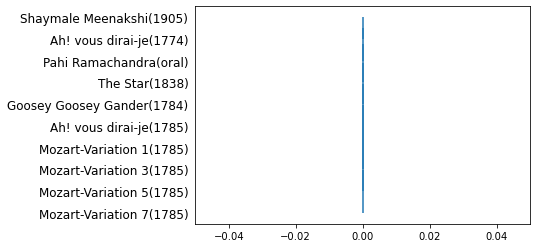

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
def llf(id):
    return data.GetLabels()[id]
Z = linkage(arrs[2], 'weighted')
fig = plt.figure()
dn = dendrogram(Z, leaf_label_func=llf, leaf_rotation=0, orientation='right')

[576.0, 769.0, 768.0, 576.0, 384.0, 580.0, 180.0, 180.0, 174.0, 159.0]

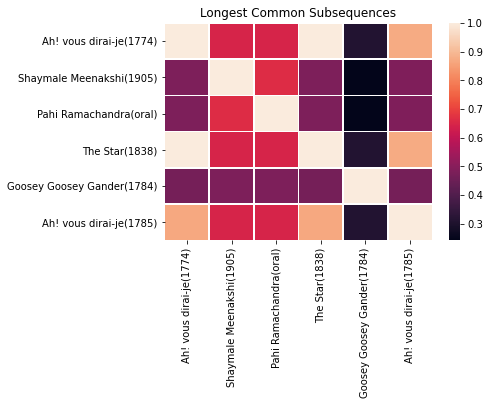

In [8]:
ax = plt.axes()
ax.set_title('Longest Common Subsequences')
seq_lens = []
for i in range(len(arrs[0])):
    seq_lens.append(arrs[0][i][i])
    arrs[0][i] /= arrs[0][i][i]

sns.heatmap(get_significant_distances(arrs[0]), linewidths=0.5, xticklabels=data.GetSignificantLabels(), yticklabels=data.GetSignificantLabels(), ax=ax)
# arrs[0].round(3)
seq_lens

array([[0.   , 0.366, 0.354, 0.   , 0.396, 0.007],
       [0.274, 0.   , 0.014, 0.274, 0.547, 0.269],
       [0.266, 0.014, 0.   , 0.266, 0.534, 0.26 ],
       [0.   , 0.366, 0.354, 0.   , 0.396, 0.007],
       [0.594, 1.096, 1.068, 0.594, 0.   , 0.604],
       [0.007, 0.357, 0.345, 0.007, 0.4  , 0.   ]])

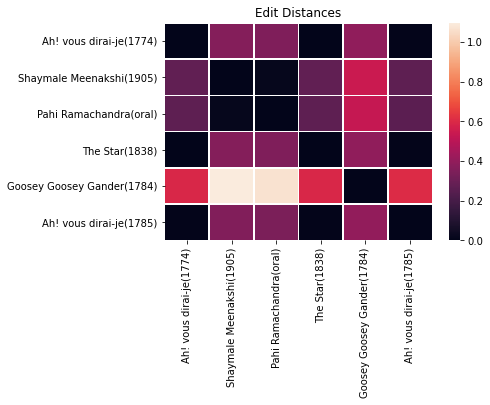

In [9]:
ax = plt.axes()
ax.set_title('Edit Distances')
for i in range(len(arrs[1])):
    arrs[1][i] /= seq_lens[i]
sns.heatmap(get_significant_distances(arrs[1]), linewidths=0.5, xticklabels=data.GetSignificantLabels(), yticklabels=data.GetSignificantLabels(), ax=ax)
get_significant_distances(arrs[1]).round(3)
# draw.draw_graph_symmetric(data.GetLabels(), arrs[1], name="edit_distances")


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

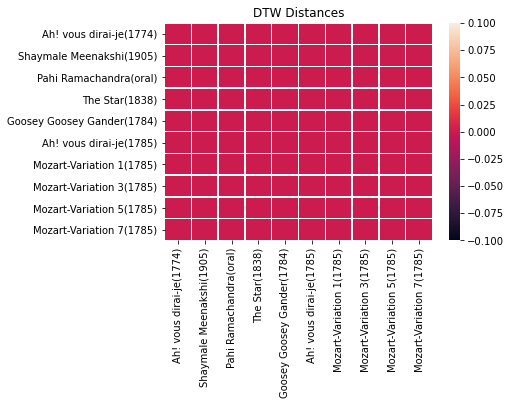

In [10]:
ax = plt.axes()
ax.set_title('DTW Distances')
tmp_np_arr = np.array(arrs[2])
tmp_np_arr += 20
sns.heatmap(arrs[2], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)#, norm=SymLogNorm(linthresh=10, vmin=tmp_np_arr.min(), vmax=tmp_np_arr.max()))
arrs[2]

In the above code snippet(s), we explore the usefulness of Edit-Distance and Hamming Distance as a distance metrics to compare two melodies. The following important inferences can be made:
![inference-image](https://images792978020.files.wordpress.com/2021/01/graphviz.png)

Pahi Ramachandra and Syamale Meenakshi are structurally very similar to one another; and are more similar to the 1785 version of Ah! vous dirai-je than any other song considered in the composition (*The Star* was first documented in 1838, which is at least 20 years after the Carnatic counterparts were found).

### CCM Causality

The following code cells shows the CCM Causality of between the chosen songs using three models: ETC-Penalty, ETC-Efficacy and LZ-Penalty. The plots are binary; i.e. the coordinate $(x, y)$ has a value $1$ if $x$ causes $y$, otherwise has a value $0$. Consequently, the causality measures are not commutative and hence, the resulting matrices are not symmetric.

<AxesSubplot:title={'center':'Causality ETCE'}>

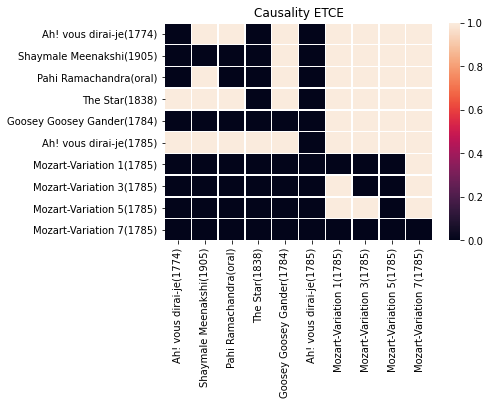

In [11]:
ax = plt.axes()
ax.set_title('Causality ETCE')
sns.heatmap(arrs[5], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

Of all the three causality measures, the ETCE returns results closest to the ground truth, as shown in the figure below. Red arrows indicate wrong causality, while the black ones indicate the correct causality.
![Causallity](https://images792978020.files.wordpress.com/2021/01/graphviz-1.png)

<AxesSubplot:title={'center':'Causality LZP'}>

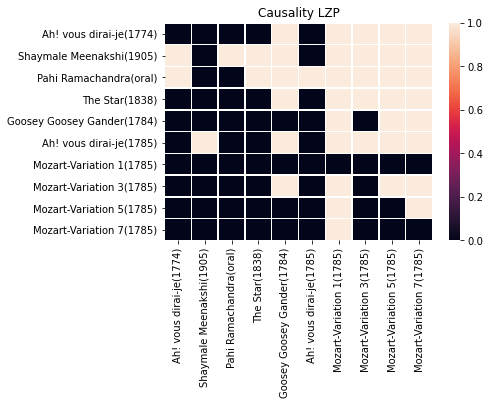

In [11]:
ax = plt.axes()
ax.set_title('Causality LZP')
sns.heatmap(arrs[5], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

<AxesSubplot:title={'center':'Causality ETCP'}>

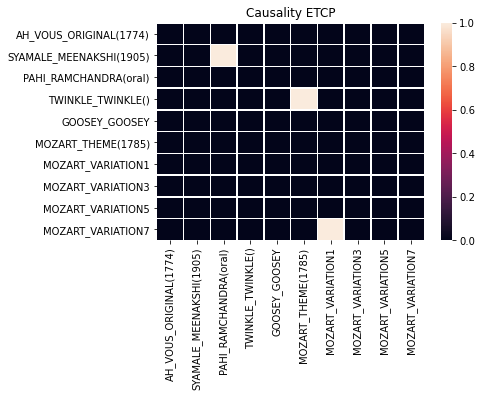

In [11]:
ax = plt.axes()
ax.set_title('Causality ETCP')
sns.heatmap(arrs[6], linewidths=0.5, xticklabels=data.GetLabels(), yticklabels=data.GetLabels(), ax=ax)

Both the LZP and the ETCE models agree that Pahi Ramachandra caused Syamale Meenakshi. If we prove that, then it will support the claim that the idea of Nottusvarams was not new when Dikshitar published his, Thyagaraja, his senior, had already composed a few before him.


In the following code snippet, we compare the notations of Syamale Meenakshi, Pahi Ramachandra and Goosey Goosey Gander measure by measure. Now, the sheet of Goosey Goosey Gander has only eight measures documented, and those eight measures are repeated twice to form sixteen measures. The notation of Pahi Ramchandra and Syamale Meenakshi are by default sixteen measures in length.

In [7]:
labels = data.GetSignificantLabels()
dicts = dicts[0:len(labels)]
matrices = create_matrix_melody_distances(dicts)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 33, 33, 33, 33, 33, 33, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 26, 26, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,

In [9]:
alt_labels = [29, 27, 28, 31, 30, '29 (1785)']

draw.draw_causal_inference(matrices[6], data_labels=labels, mela='celtic', alt_labels=alt_labels)

# ax = plt.axes()
# ax.set_title('Causality ETCE')
# sns.heatmap(matrices[5], linewidths=0.5, xticklabels=data.GetSignificantLabels(), yticklabels=data.GetSignificantLabels(), ax=ax)

digraph "" {
	graph [bb="0,0,458.2,638.21",
		rankdir=TD
	];
	node [label="\N"];
	29	[color=grey,
		fontcolor=white,
		fontsize=42,
		height=1.0607,
		pos="292.2,262.92",
		style=filled,
		width=1.3946];
	31	[color=grey,
		fontcolor=white,
		fontsize=42,
		height=1.0607,
		pos="382.2,38.184",
		style=filled,
		width=1.3946];
	29 -> 31	[pos="e,383.88,76.36 326.91,234.78 340.47,222.26 354.76,206.28 363.2,188.74 378.48,156.98 382.94,117.27 383.74,86.745",
		weight=1.0];
	"29 (1785)"	[color=grey,
		fontcolor=white,
		fontsize=42,
		height=1.0607,
		pos="195.2,150.55",
		style=filled,
		width=4.4194];
	29 -> "29 (1785)"	[pos="e,227.27,188.03 264.67,230.59 255.11,219.71 244.21,207.31 233.92,195.6",
		weight=1.0];
	"29 (1785)" -> 31	[pos="e,342.96,62.346 253.86,114.93 279.71,99.675 309.71,81.969 334.2,67.514",
		weight=1.0];
	27	[fontsize=42,
		height=1.0607,
		pos="214.2,487.65",
		width=1.3946];
	27 -> 29	[pos="e,261.84,293.81 213.38,449.23 213.97,418.06 217.88,373.1 233.2,337.1 238.55,324.

digraph "" {
	graph [bb="0,0,1254.2,587.29",
		rankdir=TD
	];
	node [label="\N"];
	"Ah! Vous Dirai-Je (1774)"	[fontsize=36,
		height=0.94281,
		pos="737.08,241.71",
		width=9.0353];
	"The Star (1838)"	[fontsize=36,
		height=0.94281,
		pos="828.08,33.941",
		width=6.03];
	"Ah! Vous Dirai-Je (1774)" -> "The Star (1838)"	[pos="e,829.44,67.982 780.82,207.77 791.71,197.43 802.23,185.17 809.08,171.76 823.84,142.89 828.31,106.34 829.24,78.286",
		weight=1.0];
	"Ah! Vous Dirai-Je(1785)"	[fontsize=36,
		height=0.94281,
		pos="483.08,137.82",
		width=8.8192];
	"Ah! Vous Dirai-Je (1774)" -> "Ah! Vous Dirai-Je(1785)"	[pos="e,562.9,170.84 657.41,208.75 630.35,197.9 599.95,185.7 572.2,174.57",
		weight=1.0];
	"Ah! Vous Dirai-Je(1785)" -> "The Star (1838)"	[pos="e,728.94,64.219 588.46,105.7 629.92,93.459 677.5,79.408 719.28,67.069",
		weight=1.0];
	"Shaymale Meenakshi (1905)"	[fontsize=36,
		height=0.94281,
		pos="419.08,449.47",
		width=10.567];
	"Shaymale Meenakshi (1905)" -> "Ah! Vous Dirai-Je (17

NameError: name 'sns' is not defined

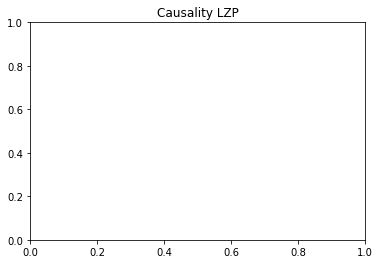

In [7]:
draw.draw_causal_inference(matrices[6], labels)
ax = plt.axes()
ax.set_title('Causality LZP')
sns.heatmap(matrices[6], linewidths=0.5, xticklabels=data.GetSignificantLabels(), yticklabels=data.GetSignificantLabels(), ax=ax)

<AxesSubplot:title={'center':'Causality ETCP'}>

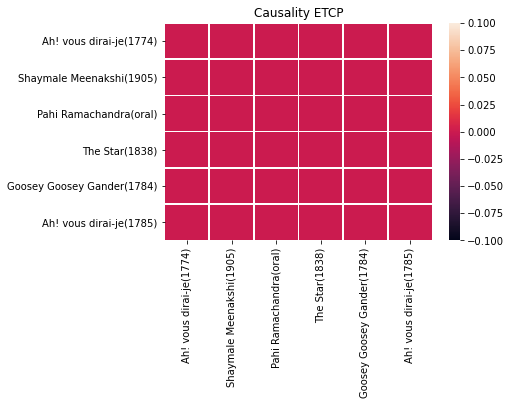

In [12]:
ax = plt.axes()
ax.set_title('Causality ETCP')
sns.heatmap(matrices[7], linewidths=0.5, xticklabels=data.GetSignificantLabels(), yticklabels=data.GetSignificantLabels(), ax=ax)

In [8]:
from utils import parallelizer

labels__ = data.GetSignificantLabels()
dicts = data.GetAll()[0:len(labels__)]
euc_datas = [data.GetEuclideanData(d, 'all')[0] for d in dicts]
euc_datas

[[(0, 0, 0.25),
  (0, 0, 0.25),
  (1, 7, 0.25),
  (1, 7, 0.25),
  (1, 9, 0.125),
  (1, 11, 0.125),
  (1, 12, 0.125),
  (1, 11, 0.125),
  (2, 7, 0.5),
  (2, 5, 0.25),
  (2, 5, 0.125),
  (2, 2, 0.125),
  (3, 4, 0.25),
  (3, 4, 0.125),
  (3, 0, 0.125),
  (3, 2, 0.25),
  (3, 2, 0.125),
  (3, -1, 0.125),
  (4, 0, 0.5),
  (4, 7, 0.25),
  (4, 7, 0.25),
  (5, 5, 0.25),
  (5, 5, 0.25),
  (5, 4, 0.25),
  (5, 4, 0.25),
  (6, 4, 0.25),
  (6, 2, 0.25),
  (6, 7, 0.25),
  (6, 7, 0.25),
  (7, 5, 0.25),
  (7, 5, 0.25),
  (7, 4, 0.25),
  (7, 4, 0.25),
  (8, 4, 0.25),
  (8, 2, 0.25),
  (8, 0, 0.25),
  (8, 0, 0.25),
  (9, 7, 0.25),
  (9, 7, 0.25),
  (9, 9, 0.125),
  (9, 11, 0.125),
  (9, 11, 0.125),
  (9, 12, 0.125),
  (10, 7, 0.5),
  (10, 5, 0.25),
  (10, 5, 0.125),
  (10, 2, 0.125),
  (11, 4, 0.25),
  (11, 4, 0.125),
  (11, 0, 0.125),
  (11, 2, 0.25),
  (11, 2, 0.125),
  (11, -1, 0.125),
  (12, 0, 0.5)],
 [(0, 0, 0.375),
  (0, 2, 0.125),
  (0, 4, 0.25),
  (0, 5, 0.25),
  (1, 7, 0.5),
  (1, 7, 0.5),
  (2

In [9]:
adj_mels = [data.GetAdjustedMelody(ed) for ed in euc_datas]
# len(adj_mels)
dists = parallelizer.list_parallelizer(distances.GetLZPCausality, adj_mels)

In [10]:

draw.draw_causal_inference(dists, labels__)

digraph "" {
	graph [bb="0,0,1642.5,483.41",
		rankdir=TD
	];
	node [label="\N"];
	"Ah! Vous Dirai-Je (1774)"	[fontsize=36,
		height=0.94281,
		pos="325.27,137.82",
		width=9.0353];
	"The Star (1838)"	[fontsize=36,
		height=0.94281,
		pos="940.27,33.941",
		width=6.03];
	"Ah! Vous Dirai-Je (1774)" -> "The Star (1838)"	[pos="e,794.43,59.101 494.54,108.78 585.1,93.779 695.85,75.431 784.31,60.778",
		weight=1.0];
	"Shaymale Meenakshi (1905)"	[fontsize=36,
		height=0.94281,
		pos="940.27,345.59",
		width=10.567];
	"Shaymale Meenakshi (1905)" -> "Ah! Vous Dirai-Je (1774)"	[pos="e,244.4,170.72 588.99,332.5 414.31,322.77 234.52,305.58 207.27,275.65 186.96,253.34 192.25,233.93 207.27,207.76 214.3,195.51 224.45,\
185.23 235.88,176.66",
		weight=1.0];
	"Shaymale Meenakshi (1905)" -> "The Star (1838)"	[pos="e,936.61,67.982 1001.4,312 1014.2,302.13 1026,290.01 1033.3,275.65 1046.8,248.7 1049.3,233.34 1033.3,207.76 1013.9,176.76 980.76,\
201.36 959.27,171.76 939.82,144.97 935.82,107.29 936.26,78.25